### *PhotoDissociation Region Toolbox Notebooks*
-------------------------------------------------------------

# Example 3: Determining Radiation Field and Density

This Example shows use the PDRT Toolbox to determine the PDR radiation field $G_0$ and hydrogen nucleus volume density $n$ from your spectral line and far-infrared (FIR) data into the PDR Toolbox.  The example shows how to make maps of $G_0$ and $n$ from your maps of observables. If you have not gone through the Measurements and ModelSets examples, you should do them first.

### 3b. Determining Radiation Field and Density from Image Measurements
Following the example on how to use Measurements, create Measurements for your image observations. Here we use the N22 [C II], [O I], and FIR maps from [Jameson et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...853..111J/abstract). 

In [1]:
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
import pdrtpy.pdrutils as utils
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.lineratioplot import LineRatioPlot
import astropy.units as u
import numpy as np

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [2]:
import pdrtpy
pdrtpy.version()

'2.0.2'

In [3]:
# get the data from the testdata directory
cii_flux = utils.get_data("n22_cii_flux.fits")  # [C II] flux
cii_err = utils.get_data("n22_cii_error.fits")  # [C II] error
oi_flux = utils.get_data("n22_oi_flux.fits")    # [O I] flux 
oi_err = utils.get_data("n22_oi_error.fits")    # [O I] error
FIR_flux = utils.get_data("n22_FIR.fits")       # FIR flux

# Output file names
cii_combined = "n22_cii_flux_error.fits"
oi_combined = "n22_oi_flux_error.fits"
FIR_combined = "n22_FIR_flux_error.fits"

# create the Measurements and write out the FITS files.
# Set overwrite=True to allow multiple runs of this notebook.
Measurement.make_measurement(cii_flux, cii_err, cii_combined,overwrite=True)
Measurement.make_measurement(oi_flux, oi_err, oi_combined,overwrite=True)
# Assign a 10% error in FIR flux
Measurement.make_measurement(FIR_flux, error='10%', outfile=FIR_combined,overwrite=True)

# Read in the FITS files to Measurements
cii_meas = Measurement.read(cii_combined, identifier="CII_158")
FIR_meas = Measurement.read(FIR_combined, identifier="FIR")
oi_meas = Measurement.read(oi_combined, identifier="OI_63")

#### Import them into the LineRatioFit tool
Here we will use the SMC models that have Z=0.1 rather than the standard set. Note these are a limited set of models with just a few lines covered.

In [4]:
smcmod = ModelSet("smc",z=0.1)
p = LineRatioFit(modelset=smcmod,measurements=[cii_meas,FIR_meas,oi_meas])
smcmod.table

numerator,denominator,ratio,filename,z,title
,,,,,null
str13,str7,str17,str17,float64,str49
OI_63,CII_158,OI_63/CII_158,oicpsmcwebcut,0.1,[O I] 63 $\mu$m / [C II] 158 $\mu$m
OI_63+CII_158,FIR,OI_63+CII_158/FIR,ciioifirwebsmccut,0.1,([O I] 63 $\mu$m + [C II] 158 $\mu$m) / I$_{FIR}$


### Now run it! 

In [5]:
p.run()

### The results are stored in member variables as Measurements.
In this case they are two-dimensional maps with NaN in the blank pixels.

In [6]:
print(p.density.shape,p.radiation_field.shape)
print("Mean density: %.1E %s"%(np.nanmean(p.density),p.density.unit))
print("Mean radiation field: %.1E %s"%(np.nanmean(p.radiation_field),p.radiation_field.unit))

(139, 81) (139, 81)
Mean density: 6.0E+03 1 / cm3
Mean radiation field: 5.8E+01 Habing


### OK let's plot some maps!
Instantiate a plotter and call the same methods as in the single pixel case.

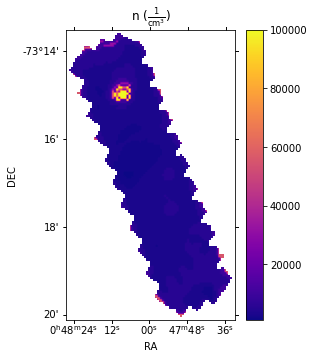

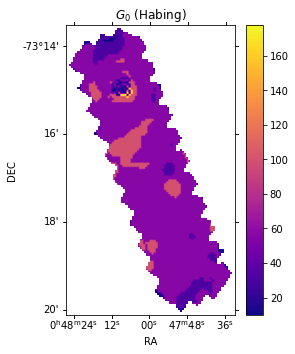

In [7]:
plot = LineRatioPlot(p)
plot.density()
plot.radiation_field()

 #### You can change the units of the image.

autolev min 5.882353 max 104.604675


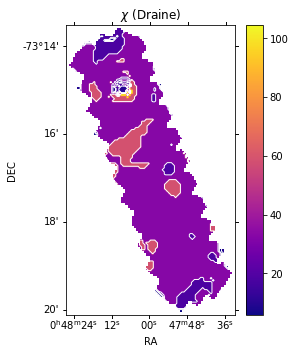

In [8]:
plot.radiation_field(units='Draine',contours=True)

### The minimum reduced $\chi^2$ as a function of RA-DEC

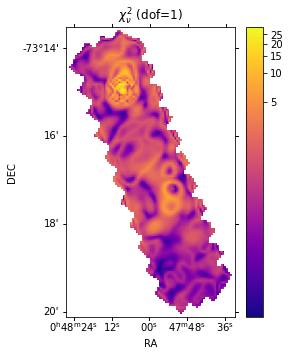

In [9]:
plot.reduced_chisq(contours=False,norm='simple')

### You can easily write out radiation field, density, and   $\chi^2$ as FITS files.
This uses the standard astropy fits I/O.

In [10]:
# use overwrite to make re-running this notbook easier
p.radiation_field.write("myradiationfield.fits",overwrite=True)
p.density.write("mydensity.fits",overwrite=True)
p.write_chisq(chi="chisq.fits",rchi="reduced_chisq.fits",overwrite=True)

#### You can show both $G_0$ and $n$ side by side with `show_both`.

In [ ]:
plot.show_both(cmap='rainbow',norm=None)

Compare these to the rightmost panels of [Figure 14](https://iopscience.iop.org/article/10.3847/1538-4357/aaa4bb#apjaaa4bbf14) of  [Jameson et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...853..111J/abstract) (ignoring colormap differences which aren't a one-to-one match).

![G0 and n from Jameson et al. 2018](jameson.png) 

Now, Jameson et al. massaged their maps to decimate oversampled pixels and fix jumps in adjacent pixels.  We can get closer to that with a bit of smoothing.

In [ ]:
from astropy.convolution import Box2DKernel, convolve
kernel = Box2DKernel(9,mode='center')
convrf = convolve(p.radiation_field, kernel)
convn = convolve(p.density,kernel)

#### Replace the data with the convolved data and replot. 

In [ ]:
p.radiation_field.data = convrf
p.density.data = convn

In [ ]:
plot.show_both(cmap='rainbow',norm='zscale')

#### That's closer to the published result.

In [ ]:
# Don't like the result? Just run the tool again to reset it!
p.run()